# Sustainable Financial Incentives Tracker - User Guide
## What This Script Does
This Google Colab notebook automatically collects sustainability related financial incentives from incentive and law databases designed for CBRE. After running the script, you'll get an organized Excel file with financial incentives (rebates, tax credits, grants, etc.) from federal, state, and other sources.

## Limitations
This script automatically parses information from the database which may yield incorrect information. Always check the link for more comprehensive eligibility and incentive rules.

## **How to Run it:**
Video tutorial: https://youtu.be/K7J_MAmih74
<br>

### **Option 1:**


*   Mac: Command + fn + F9
*   Windows: Ctrl + fn + F9

The code will began executing automatically. You can see the progress by scrolling completely down or looking at the "executing" counter on the bottom right of the website.

Once finished, the excel file should automatically be downloaded into your browser or a pop up will appear. If not, you can click the file icon on the left-bar and it will populate the


<br>

### **Option 2:**
Go to the menu bar above and click **runtime**, then click **run all**. The rest of the steps are the same.
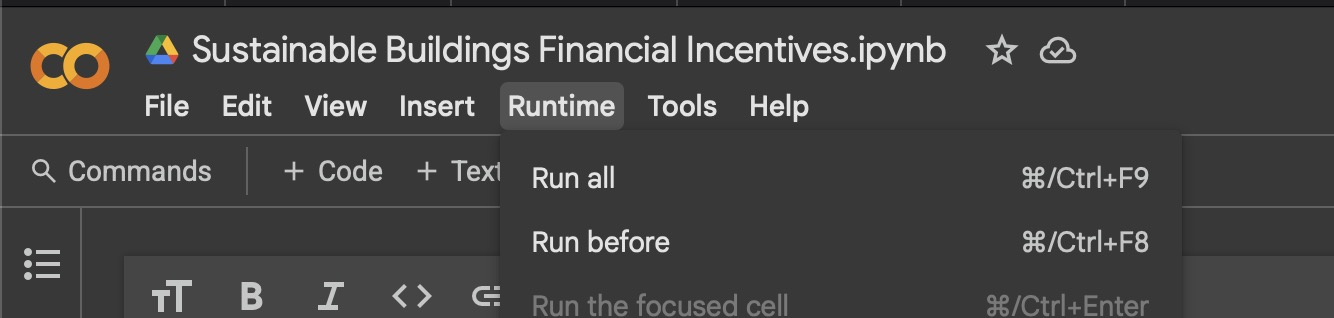




## Changing Template and Updating Data Source
This program is written entirely in Python, therefore it's fully customizable. To edit the Excel formatting it is under the format_worksheet() function

## Problems or Updates?
If there are any issues or updates needed, please contact cyraanindyaalesha@gmail.com


# Filtering Tips
Since some columns have multiple values (e.g. Commercial; Residential; Agricultural) it's recommended to filter using the "contains" feature instead of using the checklist.
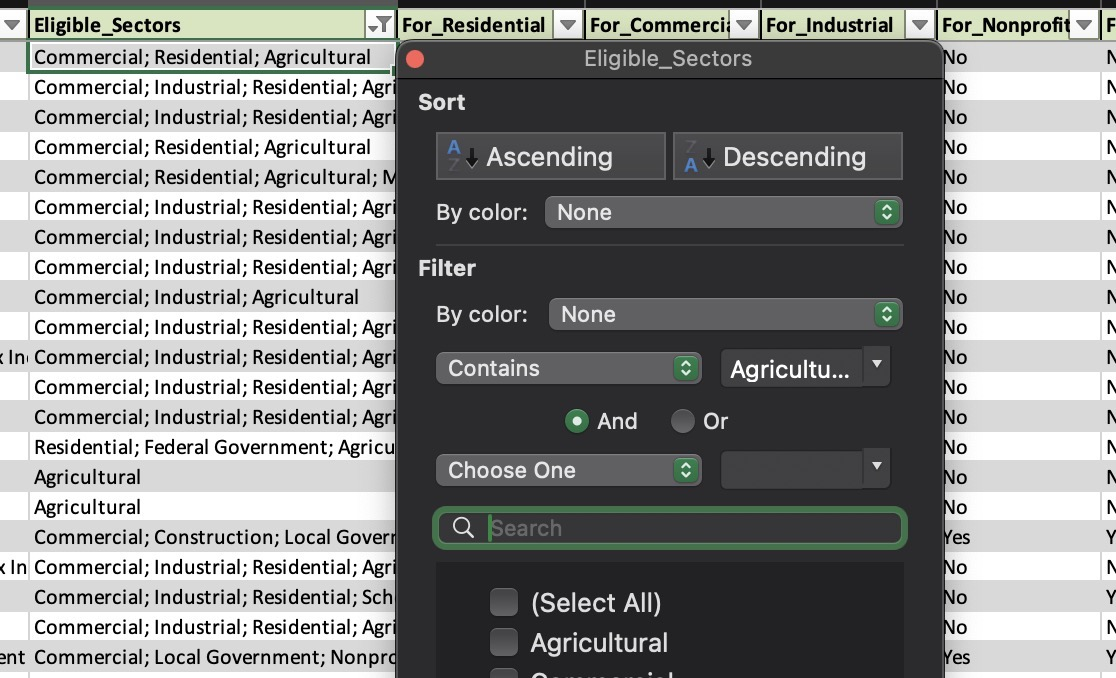


# Understanding the Sheets
The Excel file contains several sheets:

* All_Programs: Complete list of all incentives
* Federal_Incentives: Just federal programs (like ITC tax credits)
* State_Incentives: State-level incentives
* Local_Utility_Incentives: Programs from cities, counties, and utilities
* Solar_Incentives: Programs specifically for solar energy
* Renewable_Incentives: All renewable energy incentives
* Efficiency_Incentives: Energy efficiency programs
* Residential_Incentives: Programs for homeowners
* Commercial_Incentives: Programs for businesses


## Tips for Editing and Customizing the Report
To Modify Output Columns:

Find the OPTIMAL_COLUMN_ORDER list at the beginning of the script
Rearrange, add, or remove columns as needed

To Change Sheet Configurations:

Find the create_filtered_sheets function
Modify the logic for creating different Excel sheets based on your needs

To Update Formatting:

Locate the format_worksheets function
Adjust column widths, styles, and formatting as required

To Add Custom Filters:

In the process_program function, add new fields to the filtering_data dictionary
Add logic to create new filtered sheets in the create_filtered_sheets function

In [ ]:
!pip install pandas requests beautifulsoup4 xlsxwriter python-dateutil numpy files

  Preparing metadata (setup.py) ... done
  Created wheel for files: filename=files-1.1.1-py3-none-any.whl size=3649 sha256=5498ad21046ec11c9f141679858f788362926072de6f27c2776ddf35017b59e0
  Stored in directory: /root/.cache/pip/wheels/b8/6e/58/b1fda9a97300376203495d44f98f1ccccb786c17bc40a6be79
Successfully built files


In [ ]:
import requests
import pandas as pd
import json
from bs4 import BeautifulSoup
import re
import time
from datetime import datetime
import numpy as np
import os
from dateutil.parser import parse as date_parse
from google.colab import files

# Define the optimal column order for the output
OPTIMAL_COLUMN_ORDER = [
    # Core identifying information
    "Program_Name",
    "Jurisdiction",

    # Summary
    "Summary",

    # Financial details
    "Incentive_Amount",
    "Maximum_Incentive",
    "Incentive_Duration",
    "Incentive_Types",

    # Eligibility
    "Eligible_Sectors",
    "For_Residential",
    "For_Commercial",
    "For_Industrial",
    "For_Nonprofit",
    "For_Institutional",
    "For_Agricultural",
    "For_Multifamily",
    "For_Public",

    # Website
    "Direct_URL",

    # Program classification
    "Program_Type",
    "Category",
    "Policy_Types",

    # Technology details
    "Technologies",
    "Technology_Categories",
    "Energy_Categories",
    "Eligible_Equipment",
    "Equipment_Requirements",
    "Eligible_System_Size",
    "Sqft_Requirements",

    # Application info
    "Application_Process",
    "Application_Deadline",
    "Exclusions",

    # Administrative details
    "Administrator",
    "Administering_Organizations",
    "Budget",
    "Eligible_Utilities",
    "Eligible_Counties",
    "Eligible_Cities",

    # Contact information
    "Contact_People",
    "Contact_Emails",
    "Contact_Phones",
    "Contact_Websites",

    # Legal references
    "Authority_Websites",

    # Date information
    "Start_Date",
    "End_Date",
    "Last_Updated",
    "Last_Imported",



    # Net metering fields
    "Applicable_Utilities",
    "Ownership_Of_RECs"
]

# ============================== UTILITY FUNCTIONS ==============================

def safe_strip(value):
    """Safely strip a value, handling None values"""
    if value is None:
        return ""
    return str(value).strip()

def clean_html(html_text):
    """Clean HTML tags and convert to plain text"""
    if not html_text:
        return ""
    soup = BeautifulSoup(html_text, 'html.parser')
    text = soup.get_text(separator=' ', strip=True)
    return re.sub(r'\s+', ' ', text)

def format_date(date_str):
    """Format dates consistently"""
    if not date_str:
        return ""

    try:
        date_obj = date_parse(date_str)
        return date_obj.strftime("%Y-%m-%d")
    except:
        formats = ["%m/%d/%Y", "%Y-%m-%d", "%m/%d/%y"]
        for fmt in formats:
            try:
                date_obj = datetime.strptime(date_str, fmt)
                return date_obj.strftime("%Y-%m-%d")
            except:
                pass

    return date_str  # Return original if parsing fails

def format_currency(value):
    """Standardize currency format"""
    if not value:
        return ""

    # Check if it's a percentage
    if '%' in value:
        pct_match = re.search(r'(\d+(?:\.\d+)?)\s*%', value)
        if pct_match:
            return f"{float(pct_match.group(1)):.1f}%"
        return value

    # Try to extract a dollar amount
    dollar_match = re.search(r'\$?\s*([\d,]+(?:\.\d+)?)', value)
    if dollar_match:
        try:
            amount = float(dollar_match.group(1).replace(',', ''))
            return f"${amount:,.2f}"
        except:
            pass

    return value

# ============================== DATA FETCHING ==============================

def fetch_dsire_data():
    """Fetch data from the database"""
    url = "http://programs.dsireusa.org/api/v1/getprograms/json"
    print(f"Retrieving data from database")

    try:
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()
        print(f"Successfully retrieved data")
        return data
    except Exception as e:
        print(f"Error retrieving data: {e}")
        return []

# ============================== EXTRACTION FUNCTIONS BY COLUMN GROUP ==============================

def extract_core_identifying_info(program):
    """Extract core identifying information"""
    return {
        "Program_Name": safe_strip(program.get("Name", "")),
        "Jurisdiction": identify_jurisdiction(program)
    }

def extract_summary(program):
    """Extract summary information"""
    if "Summary" in program and program["Summary"]:
        summary_text = clean_html(program.get("Summary", ""))
        return {"Summary": summary_text}
    else:
        return {"Summary": ""}

def extract_incentive_details(program):
    """Extract incentive details from program parameters or summary"""
    incentive = {
        "Incentive_Amount": "",
        "Maximum_Incentive": "",
        "Equipment_Requirements": "",
        "Eligible_System_Size": "",
        "Sqft_Requirements": ""  # New field for square footage requirements
    }

    # First check if Details contains this information
    if "Details" in program and program["Details"]:
        for detail in program["Details"]:
            if "label" in detail and "value" in detail:
                label = safe_strip(detail.get("label", ""))
                value = safe_strip(detail.get("value", ""))

                if "Incentive Amount" in label:
                    incentive["Incentive_Amount"] = value
                elif "Maximum Incentive" in label:
                    incentive["Maximum_Incentive"] = value
                elif "Equipment Requirements" in label:
                    incentive["Equipment_Requirements"] = value
                elif "Eligible System Size" in label:
                    incentive["Eligible_System_Size"] = value
                elif any(size_term in label for size_term in ["Square Footage", "Sq Ft", "Size Requirement"]):
                    incentive["Sqft_Requirements"] = value

    # If still empty, try to extract from Summary
    if ("Summary" in program and program["Summary"]):
        summary = clean_html(program.get("Summary", ""))



    # Try to extract incentive amount if still empty
    if not incentive["Incentive_Amount"]:
        amount_patterns = [
            # Percentage-based incentives
            r"(\d+(?:\.\d+)?)%\s+of(?:\s+the)?\s+(?:total|system|project|cost|purchase price|installed cost|eligible project costs)",
            r"credit is (?:equal to )?(\d+(?:\.\d+)?)% of",
            r"equal to (\d+(?:\.\d+)?)% of",
            r"worth (\d+(?:\.\d+)?)% of",
            r"(?:set at|calculated at|provide) (\d+(?:\.\d+)?)% of",

            # Fixed amount incentives
            r"tax (?:credit|deduction|exemption) of (\$?[\d,]+(?:\.\d+)?)",
            r"(?:rebate|incentive|credit) of (\$?[\d,]+(?:\.\d+)?(?:\s*(?:per|for each|\/)\s*\w+)?)",
            r"flat rebate of \$?([\d,]+(?:\.\d+)?)",
            r"pays \$?([\d,]+(?:\.\d+)?) (?:per|for each)",
            r"(?:rebates|credits|incentives) (?:are|of|is) \$?([\d,]+(?:\.\d+)?)",
            r"incentive (?:amount|payment) of \$?([\d,]+(?:\.\d+)?)",
            r"credit is (?:equal to )?\$?([\d,]+(?:\.\d+)?)",
            r"incentive (?:of|at|worth|is) \$?([\d,]+(?:\.\d+)?)",
            r"direct upfront rebate of \$?([\d,]+(?:\.\d+)?)",
            r"fixed (?:at|amount of) \$?([\d,]+(?:\.\d+)?)",

            # Per unit incentives
            r"(\$?[\d.]+)(?:\s*(?:per|for each|\/)\s*(?:watt|W|kW|kWh|ton|unit|system|decatherm))",
            r"(\d+(?:\.\d+)?) cents per (?:watt|W|kW|kWh)",
            r"(\$[\d.]+)\/(?:W|watt|kW|kWh|ton|unit|kg)",
            r"(\d+(?:\.\d+)?¢)\/(?:W|watt|kW|kWh)",
            r"\$?([\d.]+) per (?:watt|kW|kWh|ton|unit|MWh)",

            # Time-based rates
            r"(\d+(?:\.\d+)?¢)\/kWh \((?:on|off)-peak\)",
            r"\$?([\d.]+)\/kWh for (?:summer|non-summer|peak|off-peak)",

            # Alternative compliance payments
            r"alternative compliance (?:payment|rate) of \$?([\d,]+(?:\.\d+)?)",
            r"compliance (?:payment|fee) of \$?([\d,]+(?:\.\d+)?)",
        ]

        # Try each pattern and stop when we find a match
        for pattern in amount_patterns:
            match = re.search(pattern, summary, re.IGNORECASE)
            if match:
                if "%" in pattern and match.group(1):
                    incentive["Incentive_Amount"] = f"{match.group(1)}% of cost"
                elif match.group(1):
                    # Format monetary amounts consistently
                    amount = match.group(1)
                    if "$" not in amount and "¢" not in amount and "/" not in amount and "cent" not in pattern:
                        # If it doesn't already have a dollar sign and isn't a rate, add one
                        incentive["Incentive_Amount"] = f"${amount}"
                    else:
                        incentive["Incentive_Amount"] = amount
                break

        # Maximum incentive patterns - if we've already found an amount but it might have a cap
        max_amount_patterns = [
            r"up to (?:a maximum of )?\$?([\d,]+(?:\.\d+)?)",
            r"(?:up to|maximum of|capped at|not to exceed) \$?([\d,]+(?:\.\d+)?)",
            r"maximum (?:rebate|incentive|credit) (?:of|is) \$?([\d,]+(?:\.\d+)?)",
            r"not (?:to )?exceed(?:ing)? \$?([\d,]+(?:\.\d+)?)",
            r"limited to \$?([\d,]+(?:\.\d+)?)",
            r"cap(?:ped)? (?:of|at) \$?([\d,]+(?:\.\d+)?)",
            r"maximum (?:of )?\$?([\d,]+(?:\.\d+)?)"
        ]

        if incentive["Incentive_Amount"] and "%" in incentive["Incentive_Amount"]:
            # If we already found a percentage, check if there's also a maximum cap
            for pattern in max_amount_patterns:
                match = re.search(pattern, summary, re.IGNORECASE)
                if match:
                    incentive["Incentive_Amount"] = f"{incentive['Incentive_Amount']} up to ${match.group(1)}"
                    break

        # Check for tiered incentive structures
        tiered_patterns = [
            r"(?:incentive|rebate)s? (?:are|range from) \$?([\d,]+(?:\.\d+)?) to \$?([\d,]+(?:\.\d+)?)",
            r"(\$[\d.]+)\/W for first [\d]+ kW, (\$[\d.]+)\/W (?:after|for)",
            r"First [\d]+-[\d]+ kW: \$?([\d.]+)\/W[\s\S]+?(?:Next|Additional) [\d]+-[\d]+ kW: \$?([\d.]+)\/W",
            r"(\$[\d.]+) for the first [\d]+ (?:kW|MW) and (\$[\d.]+) for",
            r"rates (?:are|of) \$?([\d.]+) to \$?([\d.]+)",
            r"between \$?([\d,]+(?:\.\d+)?) and \$?([\d,]+(?:\.\d+)?)",
        ]

        if not incentive["Incentive_Amount"]:
            for pattern in tiered_patterns:
                match = re.search(pattern, summary, re.IGNORECASE)
                if match:
                    incentive["Incentive_Amount"] = f"${match.group(1)} - ${match.group(2)}"
                    break

        # Check for "whichever is less" pattern
        whichever_pattern = r"(?:of|or) (\d+)% (?:of|or) \$?([\d,]+(?:\.\d+)?),? whichever is less"
        match = re.search(whichever_pattern, summary, re.IGNORECASE)
        if match and not incentive["Incentive_Amount"]:
            incentive["Incentive_Amount"] = f"${match.group(2)} or {match.group(1)}% of cost, whichever is less"

        # Check for dynamic rates
        avoided_cost_patterns = [
            r"avoided cost rate",
            r"at the utility's avoided cost",
            r"the avoided cost of wholesale power",
        ]

        if not incentive["Incentive_Amount"]:
            for pattern in avoided_cost_patterns:
                if re.search(pattern, summary, re.IGNORECASE):
                    incentive["Incentive_Amount"] = "Utility's avoided cost rate"
                    break

        # Check for specialized energy system tiers in the document format
        system_tier_pattern = r"(\d+(?:\.\d+)?) kW-DC: \$?([\d.]+)\/W-DC"
        matches = re.findall(system_tier_pattern, summary, re.IGNORECASE)
        if matches and len(matches) > 1 and not incentive["Incentive_Amount"]:
            incentive["Incentive_Amount"] = "Tiered by system size"

        # Check for per-kW or per-watt formats
        per_watt_pattern = r"\$?([\d.]+) per (?:watt|kW)"
        match = re.search(per_watt_pattern, summary, re.IGNORECASE)
        if match and not incentive["Incentive_Amount"]:
            incentive["Incentive_Amount"] = f"${match.group(1)}/watt"

        # Check for declining block or schedule-based incentives
        declining_patterns = [
            r"decreasing by \$?([\d,]+(?:\.\d+)?) (?:per|each) year",
            r"declines? (?:to|by) \$?([\d,]+(?:\.\d+)?) (?:annually|per year)",
            r"reduce(?:d|s) (?:by|to) \$?([\d,]+(?:\.\d+)?) (?:annually|per year)"
        ]

        if not incentive["Incentive_Amount"]:
            for pattern in declining_patterns:
                match = re.search(pattern, summary, re.IGNORECASE)
                if match:
                    incentive["Incentive_Amount"] = f"Declining by ${match.group(1)} per year"
                    break

        # Check for retail rate-based incentives
        retail_rate_patterns = [
            r"full retail rate",
            r"retail electric rate",
            r"credited at the utility's retail rate"
        ]

        if not incentive["Incentive_Amount"]:
            for pattern in retail_rate_patterns:
                if re.search(pattern, summary, re.IGNORECASE):
                    incentive["Incentive_Amount"] = "Full retail rate"
                    break

        # Format currency values correctly
        def format_currency(value):
            if not value:
                return value

            # Handle special cases
            if isinstance(value, str):
                # Already formatted values
                if "%" in value or "Tiered" in value or "avoided cost" in value.lower() or "retail rate" in value.lower():
                    return value

                # Already has dollar sign or is a rate
                if "$" in value or "/watt" in value or "/kW" in value:
                    return value

                # Handle range values
                if " - " in value:
                    parts = value.split(" - ")
                    formatted_parts = []
                    for part in parts:
                        if part.startswith("$"):
                            formatted_parts.append(part)
                        else:
                            formatted_parts.append(f"${part}")
                    return " - ".join(formatted_parts)

            # Handle simple dollar values
            if isinstance(value, str) and any(c.isdigit() for c in value):
                # Check if it's already a rate
                if any(x in value for x in ["/W", "/watt", "/kW", "/kWh"]):
                    if not value.startswith("$"):
                        return f"${value}"
                    return value
                # Regular dollar amount
                return f"${value}"

            return value

        incentive["Incentive_Amount"] = format_currency(incentive["Incentive_Amount"])
        incentive["Maximum_Incentive"] = format_currency(incentive["Maximum_Incentive"])

    # Extract square footage requirements from summary if not found in labels
    if not incentive["Sqft_Requirements"] and "Summary" in program and program["Summary"]:
        summary = clean_html(program.get("Summary", ""))
        sqft_patterns = [
            r"(?:minimum|maximum)?\s*(?:of\s*)?\s*(\d+(?:,\d+)?(?:\.\d+)?)\s*(?:to\s*(\d+(?:,\d+)?(?:\.\d+)?))?\s*(?:square\s*feet|sq\.\s*ft\.?|sq\s*ft)",
            r"(?:between\s*)?(\d+(?:,\d+)?(?:\.\d+)?)\s*(?:and|to)\s*(\d+(?:,\d+)?(?:\.\d+)?)\s*(?:square\s*feet|sq\.\s*ft\.?|sq\s*ft)",
            r"(?:area|size)(?:\s*of)?\s*(\d+(?:,\d+)?(?:\.\d+)?)\s*(?:square\s*feet|sq\.\s*ft\.?|sq\s*ft)",
            r"(?:square\s*feet|sq\.\s*ft\.?|sq\s*ft)(?:\s*requirement)?\s*(?:of|:)?\s*(\d+(?:,\d+)?(?:\.\d+)?)",
            r"(?:at\s*least|minimum\s*of)\s*(\d+(?:,\d+)?(?:\.\d+)?)\s*(?:square\s*feet|sq\.\s*ft\.?|sq\s*ft)",
            r"(?:up\s*to|maximum\s*of)\s*(\d+(?:,\d+)?(?:\.\d+)?)\s*(?:square\s*feet|sq\.\s*ft\.?|sq\s*ft)"
        ]

        for pattern in sqft_patterns:
            match = re.search(pattern, summary, re.IGNORECASE)
            if match:
                if match.group(2):  # Range found (min to max)
                    incentive["Sqft_Requirements"] = f"{match.group(1)} to {match.group(2)} sq ft"
                else:  # Single value
                    incentive["Sqft_Requirements"] = f"{match.group(1)} sq ft"
                break

    # FALLBACK CASE: Only use alternative extraction method if original label data is empty
    # For Incentive_Amount
    if not incentive["Incentive_Amount"]:
        financial_details = extract_financial_details(program)
        if financial_details["Incentive_Amount"]:
            incentive["Incentive_Amount"] = financial_details["Incentive_Amount"]

    # For Maximum_Incentive, only use fallback if original is empty
    if not incentive["Maximum_Incentive"]:
        # Only call extract_financial_details again if we didn't already call it above
        if "financial_details" not in locals():
            financial_details = extract_financial_details(program)
        if financial_details["Maximum_Incentive"]:
            incentive["Maximum_Incentive"] = financial_details["Maximum_Incentive"]

    return incentive


def extract_financial_details(program):
    """Extract financial details"""
    # Start with empty fields
    financial_details = {
        "Incentive_Amount": "",
        "Maximum_Incentive": "",
        "Incentive_Duration": "",
        "Incentive_Types": "",
        "Is_Financial_Incentive": "Yes" if program.get("CategoryName") == "Financial Incentive" else "No"
    }

    # Check program details for incentive amount and maximum incentive
    if "Details" in program and program["Details"]:
        for detail in program["Details"]:
            if "label" in detail and "value" in detail:
                label = safe_strip(detail.get("label", ""))
                value = safe_strip(detail.get("value", ""))
                if "Incentive Amount" in label:
                    financial_details["Incentive_Amount"] = clean_html(value)
                if "Maximum Incentive" in label:
                    financial_details["Maximum_Incentive"] = clean_html(value)

    # Extract incentive duration
    financial_details["Incentive_Duration"] = extract_incentive_duration(program)

    # Identify incentive types
    incentive_types = identify_incentive_type(program)
    financial_details["Incentive_Types"] = "; ".join(incentive_types) if incentive_types else ""

    return financial_details

def extract_incentive_duration(program):
    """Extract the duration of the incentive (one-time, ongoing, etc.)"""
    duration = ""

    # Check program details
    if "Details" in program and program["Details"]:
        for detail in program["Details"]:
            if "label" in detail and "value" in detail:
                label = safe_strip(detail.get("label", "")).lower()
                value = safe_strip(detail.get("value", ""))

                if "duration" in label or "term" in label:
                    duration = value
                    break

    # If not found in details, check summary
    if not duration and "Summary" in program and program["Summary"]:
        summary = clean_html(program["Summary"]).lower()

        # Look for common duration phrases
        if "one-time" in summary or "one time" in summary:
            duration = "One-time"
        elif "annual" in summary or "yearly" in summary:
            duration = "Annual"
        elif "monthly" in summary:
            duration = "Monthly"
        elif "ongoing" in summary or "continuous" in summary:
            duration = "Ongoing"
        # Look for specific periods
        elif "period of" in summary:
            period_match = re.search(r"period of (\d+) years", summary)
            if period_match:
                duration = f"{period_match.group(1)}-year period"

    return duration

def identify_incentive_type(program):
    """Identify the type of incentive more specifically than just program type"""
    incentive_types = []

    # Direct mapping of program types to incentive types
    program_type_map = {
        "Rebate Program": ["Rebate"],
        "Grant Program": ["Grant"],
        "Loan Program": ["Loan"],
        "PACE Financing": ["Financing", "PACE"],
        "Leasing Program": ["Lease"],
        "Energy Efficiency Performance Contract": ["Performance Contract"],
        "Personal Tax Credit": ["Tax Credit", "Personal"],
        "Corporate Tax Credit": ["Tax Credit", "Corporate"],
        "Property Tax Incentive": ["Tax Incentive", "Property"],
        "Sales Tax Incentive": ["Tax Incentive", "Sales"],
        "Production Tax Credit": ["Tax Credit", "Production"],
        "Federal Tax Credit": ["Tax Credit", "Federal"],
        "Personal Tax Deduction": ["Tax Deduction", "Personal"],
        "Corporate Tax Deduction": ["Tax Deduction", "Corporate"],
        "Federal Tax Deduction": ["Tax Deduction", "Federal"],
        "Fee Waiver": ["Fee Waiver"],
        "Performance-Based Incentive": ["Performance-Based"],
        "Feed-in Tariff": ["Feed-in Tariff"],
        "Net Metering": ["Net Metering"],
        "On-Bill Financing/On-Bill Repayment": ["Financing", "On-Bill"]
    }

    # Check program type first
    program_type = safe_strip(program.get("TypeName", ""))
    if program_type in program_type_map:
        incentive_types.extend(program_type_map[program_type])

    # If we have a numeric program type ID, use that too
    program_type_id = program.get("TypeId")
    if program_type_id is not None:
        program_type_names = {
            1: "Rebate Program",
            2: "Grant Program",
            3: "Loan Program",
            4: "PACE Financing",
            5: "Leasing Program",
            6: "Energy Efficiency Performance Contract",
            7: "Personal Tax Credit",
            8: "Corporate Tax Credit",
            9: "Property Tax Incentive",
            10: "Sales Tax Incentive",
            11: "Production Tax Credit",
            12: "Federal Tax Credit",
            13: "Personal Tax Deduction",
            14: "Corporate Tax Deduction",
            15: "Federal Tax Deduction",
            16: "Fee Waiver",
            17: "Performance-Based Incentive",
            18: "Feed-in Tariff",
            19: "Net Metering",
            36: "On-Bill Financing/On-Bill Repayment",
        }

        if program_type_id in program_type_names and program_type_names[program_type_id] in program_type_map:
            incentive_types.extend(program_type_map[program_type_names[program_type_id]])

    # Check summary for additional hints
    if "Summary" in program and program["Summary"]:
        summary = clean_html(program["Summary"]).lower()

        # Check for common types that might not be in the program type
        type_keywords = {
            "tax credit": ["Tax Credit"],
            "tax deduction": ["Tax Deduction"],
            "rebate": ["Rebate"],
            "grant": ["Grant"],
            "loan": ["Loan"],
            "cost share": ["Cost Share"],
            "financing": ["Financing"],
            "incentive payment": ["Incentive Payment"],
            "production incentive": ["Production-Based"],
            "direct payment": ["Direct Payment"],
            "bond": ["Bond"]
        }

        for keyword, types in type_keywords.items():
            if keyword in summary and not any(t in incentive_types for t in types):
                incentive_types.extend(types)

    # Deduplicate
    return list(set(incentive_types))

def extract_eligibility(program):
    """Extract eligibility information"""
    eligibility = {
        "Eligible_Sectors": "",
        "For_Residential": "No",
        "For_Commercial": "No",
        "For_Industrial": "No",
        "For_Nonprofit": "No",
        "For_Institutional": "No",
        "For_Agricultural": "No",
        "For_Multifamily": "No",
        "For_Public": "No"
    }

    # Process Sectors
    if "Sectors" in program and program["Sectors"]:
        sectors = program["Sectors"]
        sector_names = [safe_strip(sector.get("name", "")) for sector in sectors if "name" in sector]

        eligibility["Eligible_Sectors"] = "; ".join(sector_names)

        # Set sector flags
        sector_map = {
            "Residential": ["residential", "home", "house", "housing"],
            "Commercial": ["commercial", "business", "office", "retail", "restaurant", "hotel"],
            "Industrial": ["industrial", "manufacturing", "factory", "plant"],
            "Nonprofit": ["non-profit", "nonprofit", "not-for-profit", "charity"],
            "Institutional": ["school", "university", "college", "hospital", "institution"],
            "Agricultural": ["agricultural", "farm", "agriculture", "agricultural"],
            "Multifamily": ["multifamily", "multi-family", "apartment"],
            "Public": ["public", "government", "federal", "state", "local"]
        }

        for sector_type, keywords in sector_map.items():
            field_name = f"For_{sector_type}"
            if any(any(keyword in sector.lower() for keyword in keywords) for sector in sector_names):
                eligibility[field_name] = "Yes"

    return eligibility

def extract_website_info(program):
    """Extract website information"""
    website_info = {
        "Website": safe_strip(program.get("WebsiteUrl", "")),
        "Direct_URL": ""
    }

    # Try to get a direct URL from either the website, contacts, or authorities
    direct_url = extract_direct_url(program)
    if direct_url:
        website_info["Direct_URL"] = direct_url
    else:
        website_info["Direct_URL"] = website_info["Website"]

    return website_info

def extract_direct_url(program):
    """Try to extract a direct URL to the incentive rather than just the DSIRE link"""
    direct_url = ""

    # Check if website URL is available
    if "WebsiteUrl" in program and program["WebsiteUrl"]:
        direct_url = safe_strip(program["WebsiteUrl"])

    # Check contacts for website
    elif "Contacts" in program and program["Contacts"]:
        for contact in program["Contacts"]:
            if "contact" in contact and "websiteUrl" in contact["contact"] and contact["contact"]["websiteUrl"]:
                direct_url = safe_strip(contact["contact"]["websiteUrl"])
                break

    # Check authorities for website
    elif "Authorities" in program and program["Authorities"]:
        for auth in program["Authorities"]:
            if "website" in auth and auth["website"]:
                direct_url = safe_strip(auth["website"])
                break

    return direct_url

def extract_program_classification(program):
    """Extract program classification information"""
    classification = {
        "Program_Type": safe_strip(program.get("TypeName", "")),
        "Category": safe_strip(program.get("CategoryName", "")),
        #"Policy_Types": ""
    }

    # Identify policy types
    #policy_types = identify_policy_types(program)
    #classification["Policy_Types"] = "; ".join(policy_types) if policy_types else ""

    return classification

def identify_policy_types(program):
    """Identify policy types from program data and summary"""
    policy_types = []
    type_name = safe_strip(program.get("TypeName", "")).lower()
    summary_text = clean_html(program.get("Summary", "")).lower()

    # Dictionary mapping type indicators to policy names
    policy_mapping = {
        "solar/wind access policy": ["Solar Access", "Solar Easement"],
        "solar rights": ["Solar Access", "Solar Rights"],
        "easement": ["Solar Easement"] if "solar" in summary_text else [],
        "tax credit": ["Tax Credit"],
        "tax deduction": ["Tax Deduction"],
        "tax exemption": ["Tax Exemption"],
        "property tax": ["Property Tax Incentive"],
        "sales tax": ["Sales Tax Incentive"],
        "rebate": ["Rebate Program"],
        "grant": ["Grant Program"],
        "loan": ["Loan Program"],
        "interconnection": ["Interconnection"],
        "net metering": ["Net Metering"],
        "renewable portfolio": ["Renewable Portfolio Standard"],
        "generation disclosure": ["Generation Disclosure"],
        "feed-in tariff": ["Feed-in Tariff"],
        "performance-based incentive": ["Performance-Based Incentive"],
        "pace": ["PACE Financing"]
    }

    # Check TypeName first
    for key, values in policy_mapping.items():
        if key in type_name:
            policy_types.extend(values)

    # Then check summary text
    for key, values in policy_mapping.items():
        if key in summary_text and not any(v in policy_types for v in values):
            policy_types.extend(values)

    # Special cases from summary
    if "hoa" in summary_text or "homeowner's association" in summary_text or "homeowners association" in summary_text:
        if "prohibit" in summary_text and "solar" in summary_text:
            policy_types.append("HOA Solar Access Protection")

    if "community solar" in summary_text:
        policy_types.append("Community Solar")

    return list(set(policy_types))  # Remove duplicates

def extract_technology_details(program):
    """Extract technology details"""
    tech_details = {
        "Technologies": "",
        "Technology_Categories": "",
        "Energy_Categories": "",
        "Eligible_Equipment": "",
        "Equipment_Requirements": "",
        "Eligible_System_Size": "",
        "Sqft_Requirements": ""
    }

    # Process Technologies
    if "Technologies" in program and program["Technologies"]:
        tech_list = program["Technologies"]

        # Extract technology names
        tech_names = [safe_strip(tech.get("name", "")) for tech in tech_list if "name" in tech]
        tech_details["Technologies"] = "; ".join(tech_names)

        # Extract technology categories
        tech_categories = list(set([safe_strip(tech.get("category", "")) for tech in tech_list if "category" in tech]))
        tech_details["Technology_Categories"] = "; ".join(tech_categories)

        # Extract energy categories
        energy_cats = []
        for tech in tech_list:
            if "energyCategoryId" in tech:
                energy_cat_id = tech.get("energyCategoryId")
                energy_cat_map = {1: "Renewable Energy", 2: "Energy Efficiency", 3: "Transportation", 4: "Grid/Transmission"}
                if energy_cat_id in energy_cat_map:
                    energy_cats.append(energy_cat_map[energy_cat_id])

        tech_details["Energy_Categories"] = "; ".join(list(set(energy_cats)))

        # Standardize eligible equipment
        tech_details["Eligible_Equipment"] = "; ".join(standardize_equipment_list(tech_details["Technologies"]))

    # Check program details for equipment requirements and system size
    if "Details" in program and program["Details"]:
        for detail in program["Details"]:
            if "label" in detail and "value" in detail:
                label = safe_strip(detail.get("label", ""))
                value = safe_strip(detail.get("value", ""))

                if "Equipment Requirements" in label:
                    tech_details["Equipment_Requirements"] = value
                elif "Eligible System Size" in label:
                    tech_details["Eligible_System_Size"] = value
                elif any(size_term in label for size_term in ["Square Footage", "Sq Ft", "Size Requirement"]):
                    tech_details["Sqft_Requirements"] = value

    return tech_details

def standardize_equipment_list(equipment_str):
    """Standardize equipment list for consistent filtering"""
    if not equipment_str:
        return []

    # Define common equipment categories and their keywords
    equipment_categories = {
        "Solar PV": ["photovoltaic", "solar pv", "solar panel", "solar array", "solar electric"],
        "Solar Thermal": ["solar thermal", "solar hot water", "solar heating", "solar pool"],
        "Wind": ["wind turbine", "wind power", "wind energy"],
        "Geothermal": ["geothermal", "ground source heat", "ground-source"],
        "Biomass": ["biomass", "wood", "pellet", "biogas"],
        "EV Charging": ["ev", "electric vehicle", "charging station", "charger"],
        "HVAC": ["hvac", "heating", "cooling", "air conditioning", "heat pump", "furnace", "boiler"],
        "Insulation": ["insulation", "weatherization", "air sealing", "weatherstripping"],
        "Windows": ["window", "glazing"],
        "Lighting": ["lighting", "led", "light bulb", "fixture"],
        "Water Heating": ["water heat", "hot water", "tankless"],
        "Appliances": ["appliance", "refrigerator", "washer", "dryer", "dishwasher"],
        "Battery Storage": ["battery", "storage", "energy storage"],
        "Smart Thermostat": ["smart thermostat", "programmable thermostat"],
        "Fuel Cell": ["fuel cell"]
    }

    # Normalize input
    equipment_str = equipment_str.lower()

    # Identify categories present in the equipment string
    found_categories = []
    for category, keywords in equipment_categories.items():
        if any(keyword in equipment_str for keyword in keywords):
            found_categories.append(category)

    return found_categories

def extract_application_info(program):
    """Extract application information"""
    app_info = {
        "Application_Process": "",
        "Application_Deadline": "",
        "Exclusions": ""
    }

    # Extract exclusions
    app_info["Exclusions"] = extract_exclusions(program)

    # Extract application deadline and process
    deadline, process = extract_application_process_details(program)
    app_info["Application_Deadline"] = deadline
    app_info["Application_Process"] = process

    return app_info

def extract_exclusions(program):
    """Extract exclusion details from program data"""
    exclusions = []

    # Check the summary for exclusion language
    if "Summary" in program and program["Summary"]:
        summary = clean_html(program["Summary"])

        # Common exclusion phrases
        exclusion_phrases = [
            "not eligible", "not available", "excluded", "excludes",
            "does not apply", "cannot participate", "restrictions apply",
            "limited to", "must not", "only eligible if", "not qualified"
        ]

        # Look for sentences containing exclusion phrases
        sentences = re.split(r'(?<=[.!?])\s+', summary)
        for sentence in sentences:
            if any(phrase in sentence.lower() for phrase in exclusion_phrases):
                exclusions.append(sentence.strip())

    # Check program details for limitations
    if "Details" in program and program["Details"]:
        for detail in program["Details"]:
            if "label" in detail and "value" in detail:
                label = safe_strip(detail.get("label", ""))
                value = safe_strip(detail.get("value", ""))

                if any(kw in label.lower() for kw in ["limitation", "restriction", "eligibility", "exclusion"]):
                    exclusions.append(f"{label}: {value}")

    return "; ".join(exclusions)

def extract_application_process_details(program):
    """Extract application deadline and process information"""
    deadline = ""
    process = ""

    # Check program details for application information
    if "Details" in program and program["Details"]:
        for detail in program["Details"]:
            if "label" in detail and "value" in detail:
                label = safe_strip(detail.get("label", "")).lower()
                value = safe_strip(detail.get("value", ""))

                if "deadline" in label or "due date" in label:
                    deadline = value
                elif "application" in label and ("process" in label or "procedure" in label):
                    process = value

    # Check summary for application information if not found in details
    if (not deadline or not process) and "Summary" in program and program["Summary"]:
        summary = clean_html(program["Summary"])

        # Look for application deadline information
        if not deadline:
            deadline_patterns = [
                r"application(?:s)? (?:is|are) due (?:by|on) ([\w\s,]+\d{4})",
                r"deadline(?:s)? (?:is|are) ([\w\s,]+\d{4})",
                r"must apply by ([\w\s,]+\d{4})",
                r"applications accepted until ([\w\s,]+\d{4})"
            ]

            for pattern in deadline_patterns:
                match = re.search(pattern, summary, re.IGNORECASE)
                if match:
                    deadline = match.group(1).strip()
                    break

        # Look for application process information
        if not process:
            process_sentences = []
            sentences = re.split(r'(?<=[.!?])\s+', summary)
            for sentence in sentences:
                if "application" in sentence.lower() and any(word in sentence.lower() for word in ["process", "submit", "apply", "procedure", "visit", "website", "form"]):
                    process_sentences.append(sentence.strip())

            if process_sentences:
                # Limit to a reasonable length
                process = "; ".join(process_sentences[:2])

    return deadline, process

def extract_administrative_details(program):
    """Extract administrative details"""
    admin_details = {
        "Administrator": safe_strip(program.get("Administrator", "")),
        "Administering_Organizations": "",
        "Budget": safe_strip(program.get("Budget", "")),
        "Eligible_Utilities": "",
        "Eligible_Counties": "",
        "Eligible_Cities": ""
    }

    # Process Utilities
    if "Utilities" in program and program["Utilities"]:
        utilities = [safe_strip(utility.get("name", "")) for utility in program["Utilities"] if "name" in utility]
        admin_details["Eligible_Utilities"] = "; ".join(utilities)

    # Process Counties and Cities
    counties = []
    cities = []

    if "Counties" in program and program["Counties"]:
        counties = [safe_strip(county.get("name", "")) for county in program["Counties"] if "name" in county]

    if "Cities" in program and program["Cities"]:
        cities = [safe_strip(city.get("name", "")) for city in program["Cities"] if "name" in city]

    admin_details["Eligible_Counties"] = "; ".join(counties)
    admin_details["Eligible_Cities"] = "; ".join(cities)

    # Extract administering organizations from contacts
    if "Contacts" in program and program["Contacts"]:
        organizations = []
        for contact in program["Contacts"]:
            if "contact" in contact and "organizationName" in contact["contact"] and contact["contact"]["organizationName"]:
                organizations.append(safe_strip(contact["contact"]["organizationName"]))

        admin_details["Administering_Organizations"] = "; ".join(organizations)

    return admin_details

def extract_contact_information(program):
    """Extract contact information"""
    contact_info = {
        "Contact_People": "",
        "Contact_Emails": "",
        "Contact_Phones": "",
        "Contact_Websites": ""
    }

    # Process Contacts
    if "Contacts" in program and program["Contacts"]:
        contacts = program["Contacts"]

        contact_people = []
        contact_emails = []
        contact_phones = []
        contact_websites = []

        for contact in contacts:
            if "contact" in contact:
                contact_info_data = contact["contact"]

                # Contact person
                person_name = []
                if "firstName" in contact_info_data and contact_info_data["firstName"]:
                    person_name.append(safe_strip(contact_info_data["firstName"]))
                if "lastName" in contact_info_data and contact_info_data["lastName"]:
                    person_name.append(safe_strip(contact_info_data["lastName"]))
                if person_name:
                    contact_people.append(" ".join(person_name))

                # Email
                if "email" in contact_info_data and contact_info_data["email"]:
                    contact_emails.append(safe_strip(contact_info_data["email"]))

                # Phone
                if "phone" in contact_info_data and contact_info_data["phone"]:
                    contact_phones.append(safe_strip(contact_info_data["phone"]))



        contact_info["Contact_People"] = "; ".join(contact_people)
        contact_info["Contact_Emails"] = "; ".join(contact_emails)
        contact_info["Contact_Phones"] = "; ".join(contact_phones)

    return contact_info

def extract_legal_references(program):
    """Extract legal references"""
    legal_refs = {
        "Authority_Websites": ""
    }

    # Process Authorities (Legal References)
    if "Authorities" in program and program["Authorities"]:
        authorities = program["Authorities"]

        auth_websites = []

        for auth in authorities:
            if "website" in auth and auth["website"]:
                auth_websites.append(safe_strip(auth["website"]))

        legal_refs["Authority_Websites"] = "; ".join(auth_websites)

    return legal_refs

def extract_date_information(program):
    """Extract date information"""
    date_info = {
        "Start_Date": format_date(program.get("StartDate", "")),
        "End_Date": format_date(program.get("EndDate", "")),
        "Last_Updated": format_date(program.get("LastUpdate", "")),
        "Last_Imported": time.strftime("%Y-%m-%d")  # Current date
    }

    return date_info



def calculate_attractiveness_score(record):
    """Calculate an attractiveness score for filtering and sorting"""
    score = 0

    # Add points for financial incentives
    if record["Is_Financial_Incentive"] == "Yes":
        score += 5

    # Add points for having dollar amounts
    if record["Maximum_Incentive"] and any(c.isdigit() for c in record["Maximum_Incentive"]):
        try:
            # Extract numeric value if possible and add more points for higher amounts
            amount_match = re.search(r'[\$]?([\d,]+(?:\.\d+)?)', record["Maximum_Incentive"])
            if amount_match:
                amount = float(amount_match.group(1).replace(',', ''))
                if amount > 100000:
                    score += 5
                elif amount > 10000:
                    score += 4
                elif amount > 1000:
                    score += 3
                else:
                    score += 2
        except:
            score += 3  # Default if we can't parse the amount

    if record["Incentive_Amount"] and any(c.isdigit() for c in record["Incentive_Amount"]):
        # Add points for percentage-based incentives
        if "%" in record["Incentive_Amount"]:
            try:
                pct_match = re.search(r'(\d+(?:\.\d+)?)\s*%', record["Incentive_Amount"])
                if pct_match:
                    pct = float(pct_match.group(1))
                    if pct > 50:
                        score += 5
                    elif pct > 30:
                        score += 4
                    elif pct > 20:
                        score += 3
                    elif pct > 10:
                        score += 2
                    else:
                        score += 1
            except:
                score += 1  # Default if we can't parse the percentage
        else:
            score += 1

    # Additional points based on program type
    if "Tax Credit" in record["Incentive_Types"]:
        score += 3
    elif "Rebate" in record["Incentive_Types"]:
        score += 2

    # Add points for federal programs (typically more valuable)
    if record["Jurisdiction"] == "Federal":
        score += 3

    # Add points for active programs (not expired)
    if not record["End_Date"]:
        score += 2

    return score



def extract_net_metering_fields(program):
    """Extract net metering specific fields"""
    net_metering = {
        "Applicable_Utilities": "",
        "Ownership_Of_RECs": ""
    }

    # Check if this is a net metering program
    is_net_metering = False
    if program.get("TypeName", "").lower() == "net metering":
        is_net_metering = True
    elif "Summary" in program and program["Summary"] and "net metering" in program["Summary"].lower():
        is_net_metering = True

    if is_net_metering:
        # Look for applicable utilities
        if "Details" in program and program["Details"]:
            for detail in program["Details"]:
                if "label" in detail and "value" in detail:
                    label = safe_strip(detail.get("label", ""))
                    value = safe_strip(detail.get("value", ""))

                    if "Applicable Utilities" in label:
                        net_metering["Applicable_Utilities"] = value
                    elif "Ownership of Renewable Energy Credits" in label:
                        net_metering["Ownership_Of_RECs"] = value

        # Look for RECs ownership in summary
        if not net_metering["Ownership_Of_RECs"] and "Summary" in program and program["Summary"]:
            summary = clean_html(program["Summary"])
            if "customer owns" in summary.lower() and "REC" in summary:
                net_metering["Ownership_Of_RECs"] = "Customer owns RECs"

    return net_metering

def identify_jurisdiction(program):
    """Identify whether the program is federal, state, local, or utility-based"""
    # Check for known federal indicators
    federal_indicators = [
        "Federal", "U.S.", "United States", "Department of Energy", "DOE",
        "IRS", "Internal Revenue Service", "Treasury", "USDA", "HUD",
        "Federal Government", "ITC", "PTC"
    ]

    # Check program name and administrator
    program_name = safe_strip(program.get("Name", ""))
    administrator = safe_strip(program.get("Administrator", ""))

    # Check for federal indicators
    if any(indicator in program_name for indicator in federal_indicators) or \
       any(indicator in administrator for indicator in federal_indicators):
        return "Federal"

    # Check for utility indicators
    utility_indicators = ["Utility", "Power", "Electric", "Gas", "Water", "Cooperative"]
    if "Utilities" in program and program["Utilities"]:
        return "Utility"

    if any(indicator in administrator for indicator in utility_indicators):
        return "Utility"

    # Check for local indicators
    local_indicators = ["City of", "Town of", "County of", "Municipal", "Borough of", "Township"]
    if any(indicator in administrator for indicator in local_indicators):
        return "Local"

    # Check if state is specified and not federal
    if "State" in program and program["State"]:
        return "State"

    # Default to State if we can't determine
    return "State"

# ============================== MAIN PROCESSING FUNCTION ==============================

def process_program(program):
    """Process a single program into a structured record"""
    try:
        # Initialize an empty record
        record = {}

        # Extract data for each column group
        record.update(extract_core_identifying_info(program))
        record.update(extract_summary(program))
        record.update(extract_financial_details(program))
        record.update(extract_eligibility(program))
        record.update(extract_website_info(program))
        record.update(extract_program_classification(program))
        record.update(extract_technology_details(program))
        record.update(extract_application_info(program))
        record.update(extract_administrative_details(program))
        record.update(extract_contact_information(program))
        record.update(extract_legal_references(program))
        record.update(extract_date_information(program))

        # The metrics depend on other record fields, so calculate these last
        record.update(extract_net_metering_fields(program))

        # Calculate technology indicators for filtering (not in final output)
        filtering_data = {
            "has_solar": 1 if "Solar" in record.get("Technologies", "") else 0,
            "has_wind": 1 if "Wind" in record.get("Technologies", "") else 0,
            "has_biomass": 1 if "Biomass" in record.get("Technologies", "") else 0,
            "has_geothermal": 1 if "Geothermal" in record.get("Technologies", "") else 0,
            "has_hydro": 1 if "Hydro" in record.get("Technologies", "") else 0,
            "has_fuel_cells": 1 if "Fuel Cell" in record.get("Technologies", "") else 0,
            "has_renewable": 1 if "Renewable Energy" in record.get("Energy_Categories", "") else 0,
            "has_efficiency": 1 if "Energy Efficiency" in record.get("Energy_Categories", "") else 0,
            "for_residential": 1 if record.get("For_Residential", "No") == "Yes" else 0,
            "for_commercial": 1 if record.get("For_Commercial", "No") == "Yes" else 0,
            "for_industrial": 1 if record.get("For_Industrial", "No") == "Yes" else 0,
            "for_government": 1 if record.get("For_Public", "No") == "Yes" else 0,
            "jurisdiction": record["Jurisdiction"],
        }

        return record, filtering_data

    except Exception as e:
        print(f"Error processing program {program.get('ProgramId', 'unknown')}: {e}")
        return None, None

def process_dsire_data(data):
    """Process all DSIRE programs into structured records"""
    processed_records = []

    # Parse the data structure
    programs = []
    if isinstance(data, dict) and "data" in data:
        programs = data["data"]
    elif isinstance(data, list):
        programs = data

    if not programs:
        print("Warning: No program data found in API response")
        return processed_records

    # Process each program
    for program in programs:
        record, filtering_data = process_program(program)
        if record and filtering_data:
            processed_records.append((record, filtering_data))

    return processed_records

# ============================== OUTPUT FUNCTIONS ==============================

def create_excel_dashboard(records, file_path):
    """Create an Excel dashboard with formatting and filtering"""
    # Extract records and filtering data
    records_only = [record for record, _ in records]
    filtering_data = [data for _, data in records]

    # Create DataFrame from records
    df = pd.DataFrame(records_only)

    # Replace NaN values with empty strings
    df = df.replace({np.nan: ""})

    # Order columns according to OPTIMAL_COLUMN_ORDER
    ordered_columns = [col for col in OPTIMAL_COLUMN_ORDER if col in df.columns]
    missing_columns = [col for col in df.columns if col not in OPTIMAL_COLUMN_ORDER]
    ordered_columns.extend(missing_columns)
    df = df[ordered_columns]

    # Create Excel writer
    writer = pd.ExcelWriter(file_path, engine='xlsxwriter')

    # Add supplementary sheets (README, Data Dictionary)
    add_supplementary_sheets(writer)

    # Create a sheet for all programs
    df.to_excel(writer, sheet_name='All_Programs', index=False)

    # Create filtered sheets
    create_filtered_sheets(df, writer, filtering_data, records_only)

    # Format the worksheets
    format_worksheets(df, writer)



    # Close the writer
    writer.close()

def create_filtered_sheets(df, writer, filtering_data, records):
    """Create filtered sheets for different interests"""
    try:
        # Federal and State sheets
        federal_indices = [i for i, data in enumerate(filtering_data) if data['jurisdiction'] == 'Federal']
        federal_df = df.iloc[federal_indices]
        federal_df.to_excel(writer, sheet_name='Federal_Incentives', index=False)

        state_indices = [i for i, data in enumerate(filtering_data) if data['jurisdiction'] == 'State']
        state_df = df.iloc[state_indices]
        state_df.to_excel(writer, sheet_name='State_Incentives', index=False)

        local_indices = [i for i, data in enumerate(filtering_data) if data['jurisdiction'] in ['Local', 'Utility']]
        if local_indices:
            local_df = df.iloc[local_indices]
            local_df.to_excel(writer, sheet_name='Local_Utility_Incentives', index=False)


        # Solar incentives
        solar_indices = [i for i, data in enumerate(filtering_data) if data['has_solar'] == 1]
        solar_df = df.iloc[solar_indices]
        solar_df.to_excel(writer, sheet_name='Solar_Incentives', index=False)

        # Renewable Energy incentives
        renewable_indices = [i for i, data in enumerate(filtering_data) if data['has_renewable'] == 1]
        renewable_df = df.iloc[renewable_indices]
        renewable_df.to_excel(writer, sheet_name='Renewable_Incentives', index=False)

        # Energy Efficiency incentives
        efficiency_indices = [i for i, data in enumerate(filtering_data) if data['has_efficiency'] == 1]
        efficiency_df = df.iloc[efficiency_indices]
        efficiency_df.to_excel(writer, sheet_name='Efficiency_Incentives', index=False)

        # Residential incentives
        residential_indices = [i for i, data in enumerate(filtering_data) if data['for_residential'] == 1]
        residential_df = df.iloc[residential_indices]
        residential_df.to_excel(writer, sheet_name='Residential_Incentives', index=False)

        # Commercial incentives
        commercial_indices = [i for i, data in enumerate(filtering_data) if data['for_commercial'] == 1]
        commercial_df = df.iloc[commercial_indices]
        commercial_df.to_excel(writer, sheet_name='Commercial_Incentives', index=False)


    except Exception as e:
        print(f"Error creating filtered sheets: {e}")

def format_worksheets(df, writer):
    """Format all worksheets in the workbook"""
    workbook = writer.book

    # Define formats
    header_format = workbook.add_format({
        'bold': True,
        'text_wrap': True,
        'valign': 'top',
        'fg_color': '#D7E4BC',
        'border': 1,
        'font_color': 'black'  # Explicitly set font color to black
    })

    normal_format = workbook.add_format({
        'bold': False  # Explicitly set non-bold for regular cells
    })

    new_format = workbook.add_format({
        'bg_color': '#FFEB9C',  # Light yellow
        'font_color': '#9C6500'  # Dark amber
    })

    # Worksheet names for formatting
    sheet_names = [
        'All_Programs', 'Federal_Incentives', 'State_Incentives',
        'Local_Utility_Incentives', 'Financial_Incentives', 'Solar_Incentives',
        'Renewable_Incentives', 'Efficiency_Incentives', 'Residential_Incentives',
        'Commercial_Incentives'
    ]

    # Format each worksheet
    for sheet_name in sheet_names:
        if sheet_name in writer.sheets:
            worksheet = writer.sheets[sheet_name]

            # Add table style with filters
            if sheet_name == 'All_Programs':
                num_rows = len(df)
            else:
                try:
                    # Count rows in this sheet excluding header
                    num_rows = worksheet.dim_rowmax
                except:
                    # If we can't get worksheet dimensions, use a default
                    num_rows = 1000

            # First set column widths (before adding the table)
            special_widths = {
                "Program_Name": 40,
                "Summary": 60,
                "Incentive_Amount": 25,
                "Maximum_Incentive": 25,
                "Eligible_Sectors": 30,
                "Technologies": 30,
                "Application_Process": 40,
                "Exclusions": 40,
                "Contact_Emails": 25,
                "Contact_Websites": 30,
                "Website": 30,
                "Direct_URL": 30,
            }

            for i, column in enumerate(df.columns):
                if column in special_widths:
                    column_width = special_widths[column]
                else:
                    column_width = max(len(str(column)), min(20, df[column].astype(str).map(len).max()))
                    column_width = min(column_width, 30)  # Cap width at 30 characters for regular columns

                worksheet.set_column(i, i, column_width)

            # Format the first column format to NOT be bold
            worksheet.set_column(0, 0, special_widths.get("Program_Name", 30), normal_format)

            # Now add the table with a different style that has better header visibility
            if num_rows > 0:
                table_style = {
                    'style': 'Table Style Light 1',  # Changed to a style with better visibility
                    'first_column': False,  # Don't highlight first column
                    'banded_rows': True,
                    'columns': [{'header': col} for col in df.columns]
                }

                # Add the table to the worksheet
                worksheet.add_table(0, 0, num_rows, len(df.columns) - 1, table_style)

            # Set the header row to use the header format AFTER adding the table
            for col_num, value in enumerate(df.columns.values):
                worksheet.write(0, col_num, value, header_format)

            # Highlight new programs
            try:
                if 'Is_New_Program' in df.columns:
                    new_col_idx = df.columns.get_loc("Is_New_Program")
                    for row_idx in range(1, num_rows + 1):  # Start from 1 to skip header
                        cell_value = worksheet.table.get(row_idx, new_col_idx)
                        if cell_value == "Yes":
                            worksheet.set_row(row_idx, None, new_format)
            except:
                pass

            # Freeze the top row and first columns
            worksheet.freeze_panes(1, 3)

def add_supplementary_sheets(writer):
    """Add README and Data Dictionary sheets to the workbook"""
    workbook = writer.book

    # Format for headings
    title_format = workbook.add_format({
        'bold': True,
        'font_size': 16,
        'align': 'center',
        'valign': 'vcenter',
        'fg_color': '#D7E4BC',
        'border': 1
    })

    heading_format = workbook.add_format({
        'bold': True,
        'font_size': 12,
        'underline': True
    })

    normal_format = workbook.add_format({
        'font_size': 11,
        'text_wrap': True
    })



    # Add Data Dictionary sheet
    data_dict_sheet = workbook.add_worksheet('Data_Dictionary')

    # Add headers
    data_dict_sheet.write('A1', 'Column Name', title_format)
    data_dict_sheet.write('B1', 'Description', title_format)
    data_dict_sheet.write('C1', 'Data Type', title_format)
    data_dict_sheet.write('D1', 'Example Values', title_format)

    # Dictionary of column descriptions
    column_dict = {
        "Program_Name": ["Official name of the incentive or policy program", "Text", "Residential Solar Tax Credit, Energy Efficiency Rebate Program"],
        "Jurisdiction": ["Level of government or entity offering the incentive", "Text", "Federal, State, Local, Utility"],
        "Summary": ["Full summary of the program", "Text", "This program provides tax credits to homeowners..."],
        "Incentive_Amount": ["Amount or percentage of the incentive", "Text", "30% of cost, $0.25/kWh, $1,000"],
        "Maximum_Incentive": ["Maximum incentive amount available", "Text", "$10,000, $25,000 per project"],
        "Incentive_Duration": ["Duration of the incentive", "Text", "One-time, Annual, 5-year period"],
        "Incentive_Types": ["Specific types of incentives", "Text", "Tax Credit, Rebate, Grant, Loan"],
        "Is_Financial_Incentive": ["Whether the program offers financial benefits", "Text", "Yes, No"],
        "Eligible_Sectors": ["Sectors that can participate in the program", "Text", "Residential, Commercial, Industrial"],
        "For_Residential": ["Whether the program is available for residential sector", "Text", "Yes, No"],
        "For_Commercial": ["Whether the program is available for commercial sector", "Text", "Yes, No"],
        "For_Industrial": ["Whether the program is available for industrial sector", "Text", "Yes, No"],
        "For_Nonprofit": ["Whether the program is available for nonprofit sector", "Text", "Yes, No"],
        "For_Institutional": ["Whether the program is available for institutional sector", "Text", "Yes, No"],
        "For_Agricultural": ["Whether the program is available for agricultural sector", "Text", "Yes, No"],
        "For_Multifamily": ["Whether the program is available for multifamily sector", "Text", "Yes, No"],
        "For_Public": ["Whether the program is available for public sector", "Text", "Yes, No"],
        "Website": ["URL to the program on database for more information", "Text/URL", "http://programs.dsireusa.org/..."],
        "Direct_URL": ["Direct URL to the incentive program", "Text/URL", "https://www.energy.gov/..."],
        "Program_Type": ["General classification of the program type", "Text", "Tax Credit, Rebate Program, Loan Program"],
        "Category": ["Category of the program", "Text", "Financial Incentive, Regulatory Policy"],
        "Policy_Types": ["Types of policies represented", "Text", "Tax Credit, Rebate Program, PACE Financing"],
        "Technologies": ["Technologies supported by the program", "Text", "Solar Photovoltaics, Wind, Geothermal Heat Pumps"],
        "Technology_Categories": ["Categories of technologies supported", "Text", "Solar, Wind, Biomass, Geothermal"],
        "Energy_Categories": ["Broader energy categories", "Text", "Renewable Energy, Energy Efficiency"],
        "Eligible_Equipment": ["Standardized categories of eligible equipment", "Text", "Solar PV, HVAC, Battery Storage"],
        "Equipment_Requirements": ["Requirements for eligible equipment", "Text", "ENERGY STAR certified, SEER 16+"],
        "Eligible_System_Size": ["Size requirements for eligible systems", "Text", "10 kW maximum, 100 kW minimum"],
        "Sqft_Requirements": ["Square footage requirements, if applicable", "Text", "1,000 sq ft minimum, 5,000 - 50,000 sq ft"],
        "Application_Process": ["Brief description of application process", "Text", "Apply online through utility website"],
        "Application_Deadline": ["Deadline for applications", "Text/Date", "December 31, 2024, Ongoing"],
        "Exclusions": ["Restrictions or exclusions for the program", "Text", "Not available for properties under 1,000 sq ft"],
        "Administrator": ["Organization administering the program", "Text", "Department of Energy, Utility Company"],
        "Administering_Organizations": ["Organizations administering the program", "Text", "Department of Energy, Utility Company"],
        "Budget": ["Budget allocated for the program (if available)", "Text", "$50 million, $10 million annually"],
        "Eligible_Utilities": ["Utilities for which the program is available", "Text", "Pacific Gas & Electric, Duke Energy"],
        "Eligible_Counties": ["Counties for which the program is available", "Text", "Los Angeles County, Cook County"],
        "Eligible_Cities": ["Cities for which the program is available", "Text", "San Francisco, Chicago, New York"],
        "Contact_People": ["Contact persons for the program", "Text", "John Doe, Jane Smith"],
        "Contact_Emails": ["Contact email addresses", "Text", "contact@energy.gov, info@utility.com"],
        "Contact_Phones": ["Contact phone numbers", "Text", "(555) 123-4567, (800) 987-6543"],
        "Contact_Websites": ["Contact websites", "Text/URL", "https://www.energy.gov/contact"],
        "Authority_Websites": ["Websites for legal authorities", "Text/URL", "https://leginfo.legislature.ca.gov/"],
        "Start_Date": ["Date when the program began", "Date", "2022-01-01, 2023-07-15"],
        "End_Date": ["Date when the program ends (if specified)", "Date", "2026-12-31, 2025-06-30"],
        "Last_Updated": ["Date when the program data was last updated in DSIRE Database", "Date", "2023-05-15, 2024-01-20"],
        "Last_Imported": ["Date when the data was imported to our database", "Date", "2024-04-14"],
        "Program_ID": ["Unique identifier for the program", "Text/Number", "12345, 67890"],
        "Attractiveness_Score": ["Score indicating program value", "Number", "10, 15, 8"],
        "Is_New_Program": ["Whether the program is new or recently updated", "Text", "Yes, No"],
        "Searchable_Name": ["Name formatted for search", "Text", "Residential Solar Tax Credit"],
        "Quick_View": ["Concise summary of key program details", "Text", "Type: Tax Credit | Max: $10,000 | State: CA"],
        "Applicable_Utilities": ["Utilities to which net metering applies", "Text", "All IOUs, Municipal Utilities"],
        "Ownership_Of_RECs": ["Ownership of renewable energy credits", "Text", "Customer owns RECs"]
    }

    # Add data dictionary entries
    row = 1
    for col_name, [description, data_type, examples] in column_dict.items():
        row += 1
        data_dict_sheet.write(row, 0, col_name, normal_format)
        data_dict_sheet.write(row, 1, description, normal_format)
        data_dict_sheet.write(row, 2, data_type, normal_format)
        data_dict_sheet.write(row, 3, examples, normal_format)

    # Format data dictionary
    data_dict_sheet.set_column('A:A', 25)
    data_dict_sheet.set_column('B:B', 50)
    data_dict_sheet.set_column('C:C', 15)
    data_dict_sheet.set_column('D:D', 40)

# ============================== MAIN FUNCTION ==============================

def main():
    # Fetch data from API
    data = fetch_dsire_data()

    if not data:
        print("No data retrieved. Exiting.")
        return

    # Process the data
    print("Processing data...")
    all_records = process_dsire_data(data)

    if not all_records:
        print("No records were processed. Check data format.")
        return

    # Filter to keep only financial incentives
    print("Filtering to include only financial incentives...")
    financial_records = []

    for record, filtering_data in all_records:
        # Check if this is a financial incentive based on CategoryName
        if record["Is_Financial_Incentive"] == "Yes":
            financial_records.append((record, filtering_data))

    print(f"Found {len(financial_records)} financial incentives out of {len(all_records)} total records")

    # Save to enhanced Excel dashboard
    timestamp = time.strftime("%b_%d_%Y_%I%M%p")
    excel_file = f"sustainability_financial_incentives_{timestamp}.xlsx"

    # Create the Excel dashboard
    create_excel_dashboard(financial_records, excel_file)

    print(f"Successfully processed data and saved to {excel_file}")
    print(f"- Removed non-financial incentives")
    print(f"- Created separate sheets for Federal, State, and Local/Utility incentives")
    print(f"- Added standardized fields for eligibility, equipment, and incentive details")
    print(f"- Created comprehensive Data Dictionary and README")
    files.download(excel_file)

if __name__ == "__main__":
    main()

Retrieving data from database
Successfully retrieved data
Processing data...
Filtering to include only financial incentives...
Found 1855 financial incentives out of 2542 total records
Successfully processed data and saved to sustainability_financial_incentives_20250520_153426.xlsx
- Removed non-financial incentives
- Created separate sheets for Federal, State, and Local/Utility incentives
- Added standardized fields for eligibility, equipment, and incentive details
- Created comprehensive Data Dictionary and README


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>